# Proyecto Final de Redes Neuronales

*   Maestría en Ciencia de Datos
*   Profesor: Dr. Julio Waissman Vilanova
*   Alumno: Carlos Alejandro Velázquez Valdez

<p align="center">
  <img src="https://raw.githubusercontent.com/Nixtla/neuralforecast/main/nbs/imgs_indx/logo_mid.png" />
</p>

NeuralForecast ofrece una amplia colección de modelos neuronales de forecasting centrados en su utilidad y robustez. Los modelos van desde redes clásicas como MLP, RNNs hasta los mas novedosos como NBEATS, NHITS, TFT y otras arquitecturas.

In [0]:
# Instalamos librerias necesarias
!pip install neuralforecast

     |████████████████████████████████| 90 kB 4.5 MB/s 
     |▏                               | 3.4 MB 37.3 MB/s et

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 317.1 MB 9.1 kB/s 
     |████████████████████████████████| 51 kB 8.0 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Not uninstalling typing-extensions at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-fa0ba031-61e4-4528-bab5-b9d0b822c75e
    Can't uninstall 'typing-extensions'. No files were found to uninstall.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Not uninstalling numpy at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-fa0ba031-61e4-4528-bab5-b9d0b822c75e
    Can't uninstall 'numpy'. No files were found to uninstall.
  Attempting uninstal

In [0]:
# Importamos librerias necesarias
import numpy as np
import pandas as pd
from neuralforecast.utils import AirPassengersDF
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS, RNN, GRU, TFT, NBEATS, NBEATSx
from neuralforecast.auto import AutoLSTM, AutoNHITS
from neuralforecast.losses.pytorch import MAPE


from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

from ray import tune
import plotly.graph_objects as go



## Data Loading & Formatting

A continuación cargaremos los datos de un repositorio de github (lo ideal sería ya tenerlos en el delta lake), realizaremos una limpieza sencilla y les daremos el formato que requiere la librería.

In [0]:
#Data Reading
df =  pd.read_csv('https://raw.githubusercontent.com/carlosvelv/temp/main/DatasetHMO_01012016_29092022.csv')
df.head()

#Data cleaning
df.drop_duplicates(subset = ['Date'], inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df_test = df.query('Date > 20220801')
df_test = df_test.query('Date < 20220803')
df = df.query('Date < 20220801')

df = df[df.Demand != 0].copy()
df.set_index('Date', inplace = True)
df = df.asfreq('H', method='pad')
df['Mes'] = df.index.month
df['Semana'] = df.index.weekofyear
df['Dia'] = df.index.weekday
df['Hora'] = df.index.hour
df.reset_index( inplace=True)
df = df[['Date','Demand']].copy()
df

,Date,Demand
0,2016-01-02 00:00:00,225.622
1,2016-01-02 01:00:00,213.620
2,2016-01-02 02:00:00,207.360
3,2016-01-02 03:00:00,201.374
4,2016-01-02 04:00:00,199.018
...,...,...
57667,2022-07-31 19:00:00,610.326
57668,2022-07-31 20:00:00,609.114
57669,2022-07-31 21:00:00,610.594
57670,2022-07-31 22:00:00,619.377


In [0]:
df.rename({'Date':'ds', 'Demand':'y'}, axis=1, inplace=True)
df['unique_id'] = 1.0
df

,ds,y,unique_id
0,2016-01-02 00:00:00,225.622,1.0
1,2016-01-02 01:00:00,213.620,1.0
2,2016-01-02 02:00:00,207.360,1.0
3,2016-01-02 03:00:00,201.374,1.0
4,2016-01-02 04:00:00,199.018,1.0
...,...,...,...
57667,2022-07-31 19:00:00,610.326,1.0
57668,2022-07-31 20:00:00,609.114,1.0
57669,2022-07-31 21:00:00,610.594,1.0
57670,2022-07-31 22:00:00,619.377,1.0


## Probando modelos univariantes de forecasting
Los modelos de series temporales univariantes son una clase de especificaciones en las que se intenta modelizar y predecir variables financieras utilizando únicamente la información contenida en sus propios valores pasados y, posiblemente, los valores actuales y pasados de un término de error. A continuación probaremos diferentes modelos.

In [0]:
%%capture
horizon = 24

# Try different hyperparmeters to improve accuracy.
models = [LSTM(h=horizon,                    # Forecast horizon
               max_epochs=200,               # Number of epochs to train
               input_size=168,
               scaler_type='standard',       # Type of scaler to normalize data
               encoder_hidden_size=64,       # Defines the size of the hidden state of the LSTM
               decoder_hidden_size=64,),     # Defines the number of hidden units of each layer of the MLP decoder
          NHITS(h=horizon,                   # Forecast horizon
                input_size=168,      # Length of input sequence
                max_epochs=200,              # Number of epochs to train
                n_freq_downsample=[2, 1, 1]),
          NBEATS(h=24, input_size=168,
               loss=MAPE(),
               stack_types = ['identity', 'trend', 'seasonality'],
               max_epochs=200),
          NBEATSx(h=24, input_size=168,
                loss=MAPE(),
                scaler_type='standard',
                max_epochs=200),
          RNN(h=24, input_size=168,
                loss=MAPE(),
                scaler_type='robust',
                encoder_n_layers=2,
                encoder_hidden_size=128,
                context_size=10,
                decoder_hidden_size=128,
                decoder_layers=2,
                max_epochs=500) 
          ]


In [0]:
%%capture
model = NeuralForecast(models=models, freq='H')
model.fit(df=df)

In [0]:
%%capture
Y_hat_df = model.predict()


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Out[17]: <AxesSubplot:xlabel='ds'>

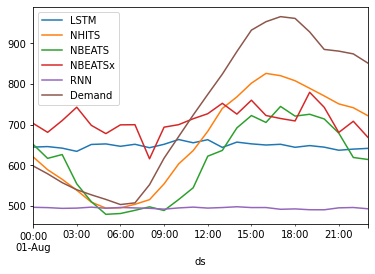

In [0]:
plot_df = Y_hat_df.reset_index(drop=True).join(df_test.Demand.reset_index(drop=True)).set_index('ds')
plot_df.plot()

In [0]:
plot_df.head(2)

,LSTM,NHITS,NBEATS,NBEATSx,RNN,Demand
ds,,,,,,
2022-08-01 00:00:00,644.712402,620.704407,651.507080,703.202209,496.496887,598.399
2022-08-01 01:00:00,645.946533,589.023071,616.969238,681.068848,495.721069,578.968


In [0]:
# Calculamos MAPE

dict = {}

for model in plot_df.iloc[:,1:-1].columns:
    actual = plot_df.Demand.values
    pred = plot_df[model].values
    ape = np.abs((actual - pred) / actual)
    mape = np.mean(ape) * 100

    dict[model] = mape


In [0]:
dict

Out[23]: {'NHITS': 9.253552483865864,
 'NBEATS': 17.033522751085485,
 'NBEATSx': 20.54450157704956,
 'RNN': 28.600344240940572}

Al ver el forecast de los modelos probados, observamos que el modelo que nos dio mejores resultados es NHITS, por lo que optimizaremos los hiperparámetros de este.